# SWB analysis pipeline part 4: 

Freq-Band Averaged Time Courses - Single ROI

*Created: 07/14/24* \
*Updated: XX/XX/2024*


In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm



import warnings
warnings.filterwarnings('ignore')




In [2]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08012024


In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *

In [4]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [5]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [6]:
### load ROI reref master 
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])
roi_reref_labels_master_df



,subj_id,reref_ch_names,ch_label4roi,ch_type4roi,loc4roi,mni_x,mni_y,mni_z,hemi,roi
0,MS002,lacas1-lacas2,lacas1,anode,left cingulate gyrus d,-6.382462,37.158688,-3.130044,l,acc
1,MS002,lacas2-lacas3,lacas2,anode,left cingulate gyrus e,-6.368174,38.606223,2.270621,l,acc
2,MS002,lacas3-lacas4,lacas3,anode,left cingulate gyrus f,-6.390079,39.941566,7.640265,l,acc
3,MS002,lacas4-lacas5,lacas4,anode,left cingulate gyrus f,-6.914519,41.546899,12.993427,l,acc
4,MS002,lacas5-lacas6,lacas5,anode,left cingulate gyrus g,-6.933604,42.745784,18.267675,l,acc
...,...,...,...,...,...,...,...,...,...,...
1875,DA039,rtp6-rtp7,rtp6,anode,right superior middle temporal pole d,40.532268,7.354525,-33.253436,r,temporal pole
1876,DA039,rtp7-rtp8,rtp7,anode,right superior middle temporal pole d,43.911226,7.341369,-31.915085,r,temporal pole
1877,DA039,rsgcc6-rsgcc7,rsgcc7,cathode,right anterior pars triangularis b,42.378987,31.277597,2.471854,r,vlpfc
1878,DA039,rsgcc7-rsgcc8,rsgcc7,anode,right anterior pars triangularis b,42.378987,31.277597,2.471854,r,vlpfc


# Get data 

In [7]:
freqs = {'hfa':np.array([70,200]),'gamma':np.array([30,70]),'beta':np.array([13,30]),
         'alpha':np.array([9,13]),'theta':np.array([4,9]),'delta':np.array([2,4])}

In [8]:
### plot_roi = roi str according to roi_reref_labels_master
plot_roi   = 'dmpfc'
### plot_band = str id of band to plot
plot_band  = 'beta'
### freq_range = np array of upper/lower freq bounds of plot_band - either manual or subset from freqs above
# freq_range = np.array([9,12])
freq_range = freqs[plot_band]

In [9]:
roi_df = roi_reref_labels_master_df[roi_reref_labels_master_df.roi == plot_roi]
roi_df['unique_reref_ch'] = roi_df[['subj_id', 'reref_ch_names']].agg('_'.join, axis=1)
roi_subjs  = roi_df.subj_id.unique().tolist()
roi_elecs  = {f'{subj}':roi_df[roi_df.subj_id == subj].unique_reref_ch.tolist() for subj in roi_subjs}
roi_elecs  = {f'{subj}':roi_df[roi_df.subj_id == subj].reref_ch_names.tolist() for subj in roi_subjs}

roi_elecs

{'MS002': ['lacas6-lacas7',
  'lacas7-lacas8',
  'lacas8-lacas9',
  'lacas9-lacas10',
  'laims10-laims11',
  'laims11-laims12',
  'laims12-laims13',
  'laims13-laims14',
  'lpips12-lpips13',
  'racas6-racas7',
  'racas7-racas8',
  'racas8-racas9',
  'racas12-racas13'],
 'MS003': ['lacas8-lacas9',
  'lacas9-lacas10',
  'lmcms4-lmcms5',
  'lmcms8-lmcms9',
  'racas6-racas7',
  'racas7-racas8',
  'racas8-racas9',
  'racas9-racas10',
  'racas10-racas11',
  'rmcms4-rmcms5',
  'rmcms7-rmcms8',
  'rmcms8-rmcms9'],
 'MS009': ['lacas7-lacas8',
  'lacas8-lacas9',
  'lacas9-lacas10',
  'lmcms4-lmcms5'],
 'MS011': ['rmcps4-rmcps5', 'rmcps5-rmcps6'],
 'MS015': ['lacas3-lacas4',
  'lacas5-lacas6',
  'lmcms4-lmcms5',
  'lmcms7-lmcms8',
  'rmcms1-rmcms2',
  'rmcms2-rmcms3',
  'rmcms5-rmcms6',
  'rpem2-rpem3',
  'rpem3-rpem4'],
 'MS016': ['laimm10-laimm11',
  'laimm11-laimm12',
  'laimm12-laimm13',
  'laimm13-laimm14',
  'lmcms4-lmcms5',
  'lmcms7-lmcms8',
  'lmcms8-lmcms9'],
 'MS017': ['lacas6-lacas7',

In [10]:
roi_band_pow = {}
roi_metadata = {}

for subj_id in roi_subjs:
    
    # load cpe power epochs for single subject 
    power_epochs = mne.time_frequency.read_tfrs(f'{neural_dir}{subj_id}/{subj_id}_CpeOnset-tfr.h5')[0]
    roi_epochs   = power_epochs.copy().pick_channels(roi_elecs[subj_id])
    del power_epochs
    
    roi_pow_df  = roi_epochs.to_data_frame()
    roi_band_df = roi_pow_df[(roi_pow_df.freq >= freq_range[0])&(roi_pow_df.freq <= freq_range[1])].groupby(
                  ['epoch','time']).agg('mean').reset_index()
    
    roi_band_df  = roi_band_df.melt(id_vars=['epoch','time','freq'],
                                    value_vars=roi_elecs[subj_id],
                                    var_name='reref_ch_names', value_name='band_pow',
                                    ignore_index = False)
    
    roi_band_pow[subj_id] = roi_band_df
    roi_metadata[subj_id] = roi_epochs.metadata.copy()   
    del roi_epochs, roi_pow_df, roi_band_df 
    
     

    

Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/MS002_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS003/MS003_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/MS009_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS011/MS011_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/MS015_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS016/MS016_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS017/MS017_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns
Reading /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS019/MS019_CpeOnset-tfr.h5 ...
Adding metadata with 19 

In [11]:
##### regressors to zscore for plot data 
continuous_regressors = ['decisionCPE','TrialEV','TotalProfit','decisionRegret','decisionRelief','RPE','Profit']


In [12]:
plot_dfs = []

### update metadata - zscore continuous regressors + add RT info
for subj_id in roi_metadata.keys():
    metadata_df          = roi_metadata[subj_id].reset_index()
    metadata_df['epoch'] = metadata_df.Round-1
    
    roi_df      = roi_band_pow[subj_id]
    roi_df      = roi_df.set_index('epoch')
    
    # merge pow and metadata dfs keeping epoch as index 
    roi_regression_df = pd.merge(roi_df, metadata_df,left_on=['epoch'],
                                right_on=['epoch']).reset_index(drop=True).set_index('epoch')
    
    roi_regression_df  = roi_regression_df[roi_regression_df.RT>0.3].reset_index(drop=True)
    roi_regression_df  = roi_regression_df[roi_regression_df.Round != 76].reset_index(drop=True)
    roi_regression_df  = roi_regression_df[roi_regression_df.decisionCPE != 0]
    
    roi_regression_df['cpe']             = roi_regression_df.decisionCPE.copy()
    roi_regression_df['cpe_split']       = roi_regression_df['cpe'].apply(lambda x: 0 if x < 0 else 1)
    roi_regression_df['TrialEV']         = roi_regression_df.GambleEV - roi_regression_df.SafeBet
    roi_regression_df['GambleChoice']    = roi_regression_df['GambleChoice'].astype('category')
    roi_regression_df['TrialType']       = roi_regression_df['TrialType'].astype('category')
    roi_regression_df['epoch_num']       = roi_regression_df.index # keep epoch as a column
    roi_regression_df['subj_id']         = subj_id
    roi_regression_df['roi']             = plot_roi
    roi_regression_df['bdi']             = subj_info_df[subj_info_df.subj_id == subj_id].bdi.values[0]
    roi_regression_df['unique_reref_ch'] = roi_regression_df[['subj_id', 'reref_ch_names']].agg('_'.join, axis=1)
    
    
#         # zscore continuous regressors AFTER removing bad trials!! 
    for reg in continuous_regressors:
        roi_regression_df[reg] = norm_zscore(roi_regression_df[reg].values) # zscore is /2std

    plot_dfs.append(roi_regression_df)
      

In [13]:
roi_plot_df = pd.concat(plot_dfs).reset_index()

In [14]:
roi_plot_df

,level_0,time,freq,reref_ch_names,band_pow,index,Round,RT,CpeOnset,GambleChoice,...,decisionRelief,decisionCF,cpe,cpe_split,TrialEV,epoch_num,subj_id,roi,bdi,unique_reref_ch
0,0,0.000,20.743342,lacas6-lacas7,1.774755,0,1,2.059852,517.450091,safe,...,-0.393361,0.57,-0.57,0,-0.431195,0,MS002,dmpfc,14,MS002_lacas6-lacas7
1,1,0.002,20.743342,lacas6-lacas7,1.772305,0,1,2.059852,517.450091,safe,...,-0.393361,0.57,-0.57,0,-0.431195,1,MS002,dmpfc,14,MS002_lacas6-lacas7
2,2,0.004,20.743342,lacas6-lacas7,1.758869,0,1,2.059852,517.450091,safe,...,-0.393361,0.57,-0.57,0,-0.431195,2,MS002,dmpfc,14,MS002_lacas6-lacas7
3,3,0.006,20.743342,lacas6-lacas7,1.734679,0,1,2.059852,517.450091,safe,...,-0.393361,0.57,-0.57,0,-0.431195,3,MS002,dmpfc,14,MS002_lacas6-lacas7
4,4,0.008,20.743342,lacas6-lacas7,1.700175,0,1,2.059852,517.450091,safe,...,-0.393361,0.57,-0.57,0,-0.431195,4,MS002,dmpfc,14,MS002_lacas6-lacas7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46199274,1110735,2.992,20.743342,lac10-lac11,-0.674195,149,150,1.476687,1926.411432,gamble,...,0.448646,0.40,0.86,1,0.436063,1110735,DA023,dmpfc,14,DA023_lac10-lac11
46199275,1110736,2.994,20.743342,lac10-lac11,-0.674153,149,150,1.476687,1926.411432,gamble,...,0.448646,0.40,0.86,1,0.436063,1110736,DA023,dmpfc,14,DA023_lac10-lac11
46199276,1110737,2.996,20.743342,lac10-lac11,-0.672338,149,150,1.476687,1926.411432,gamble,...,0.448646,0.40,0.86,1,0.436063,1110737,DA023,dmpfc,14,DA023_lac10-lac11
46199277,1110738,2.998,20.743342,lac10-lac11,-0.668792,149,150,1.476687,1926.411432,gamble,...,0.448646,0.40,0.86,1,0.436063,1110738,DA023,dmpfc,14,DA023_lac10-lac11


# Start plotting

In [15]:
sns.set_context('talk')
sns.set_style('ticks')



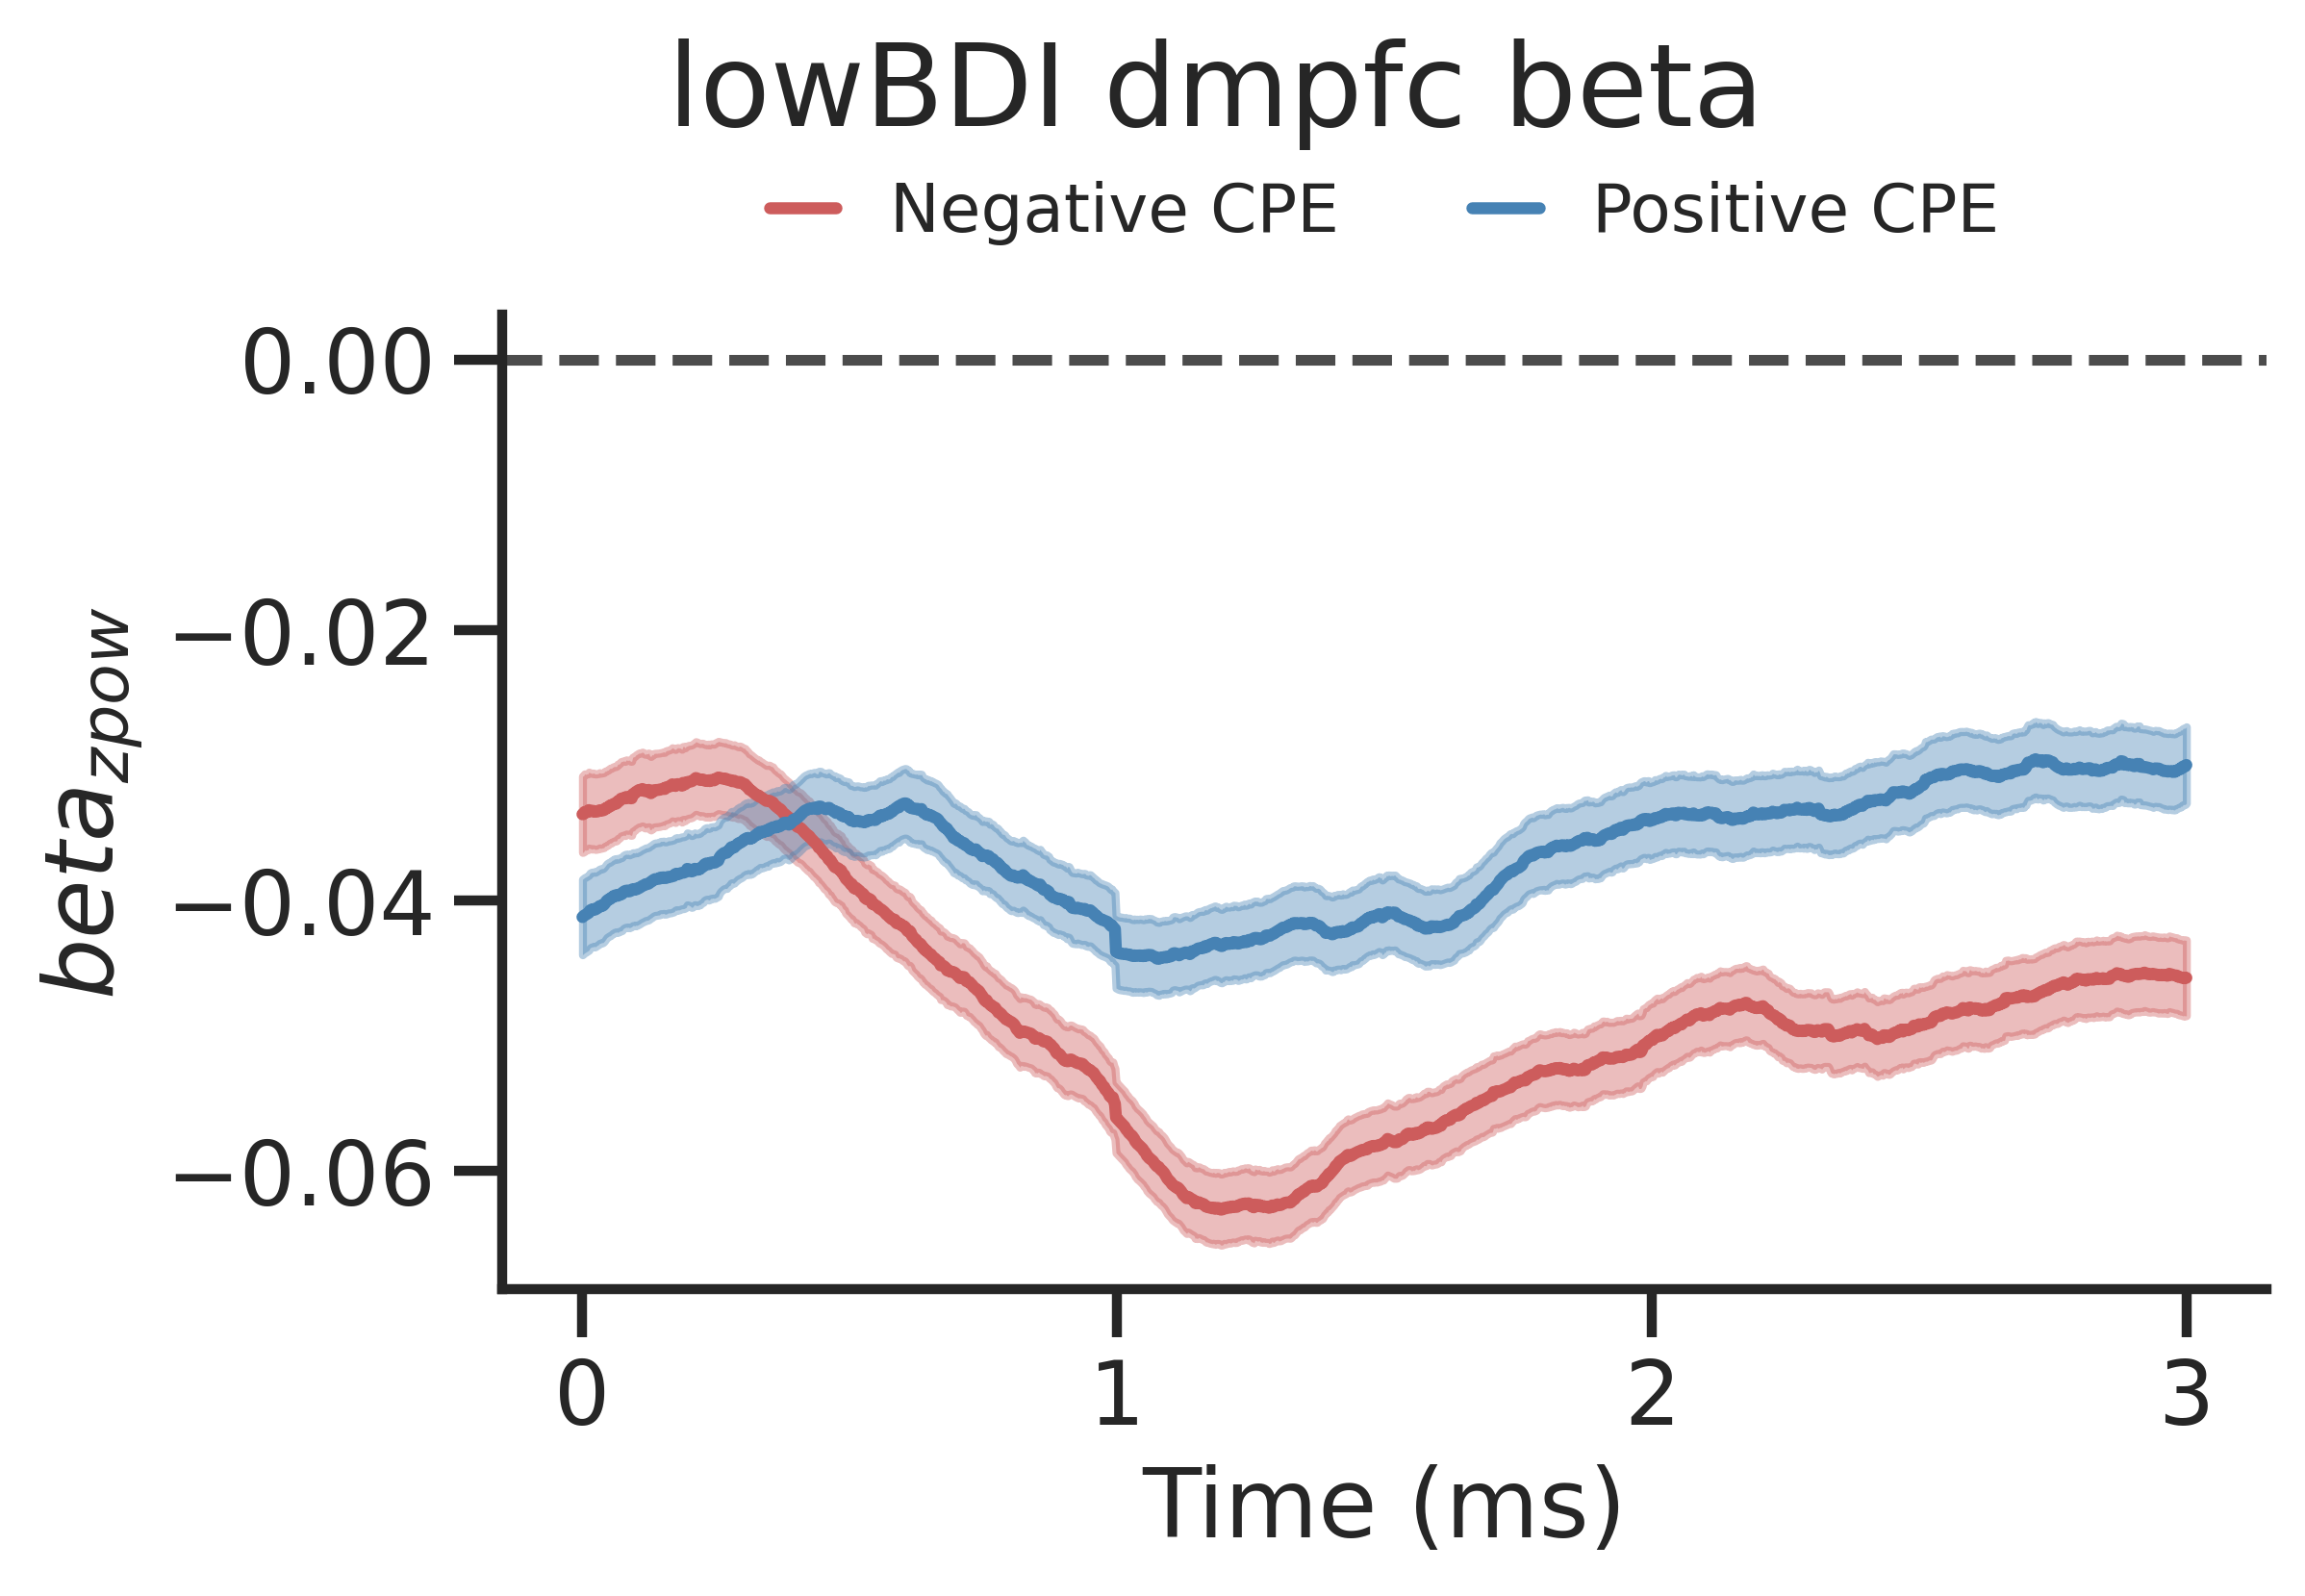

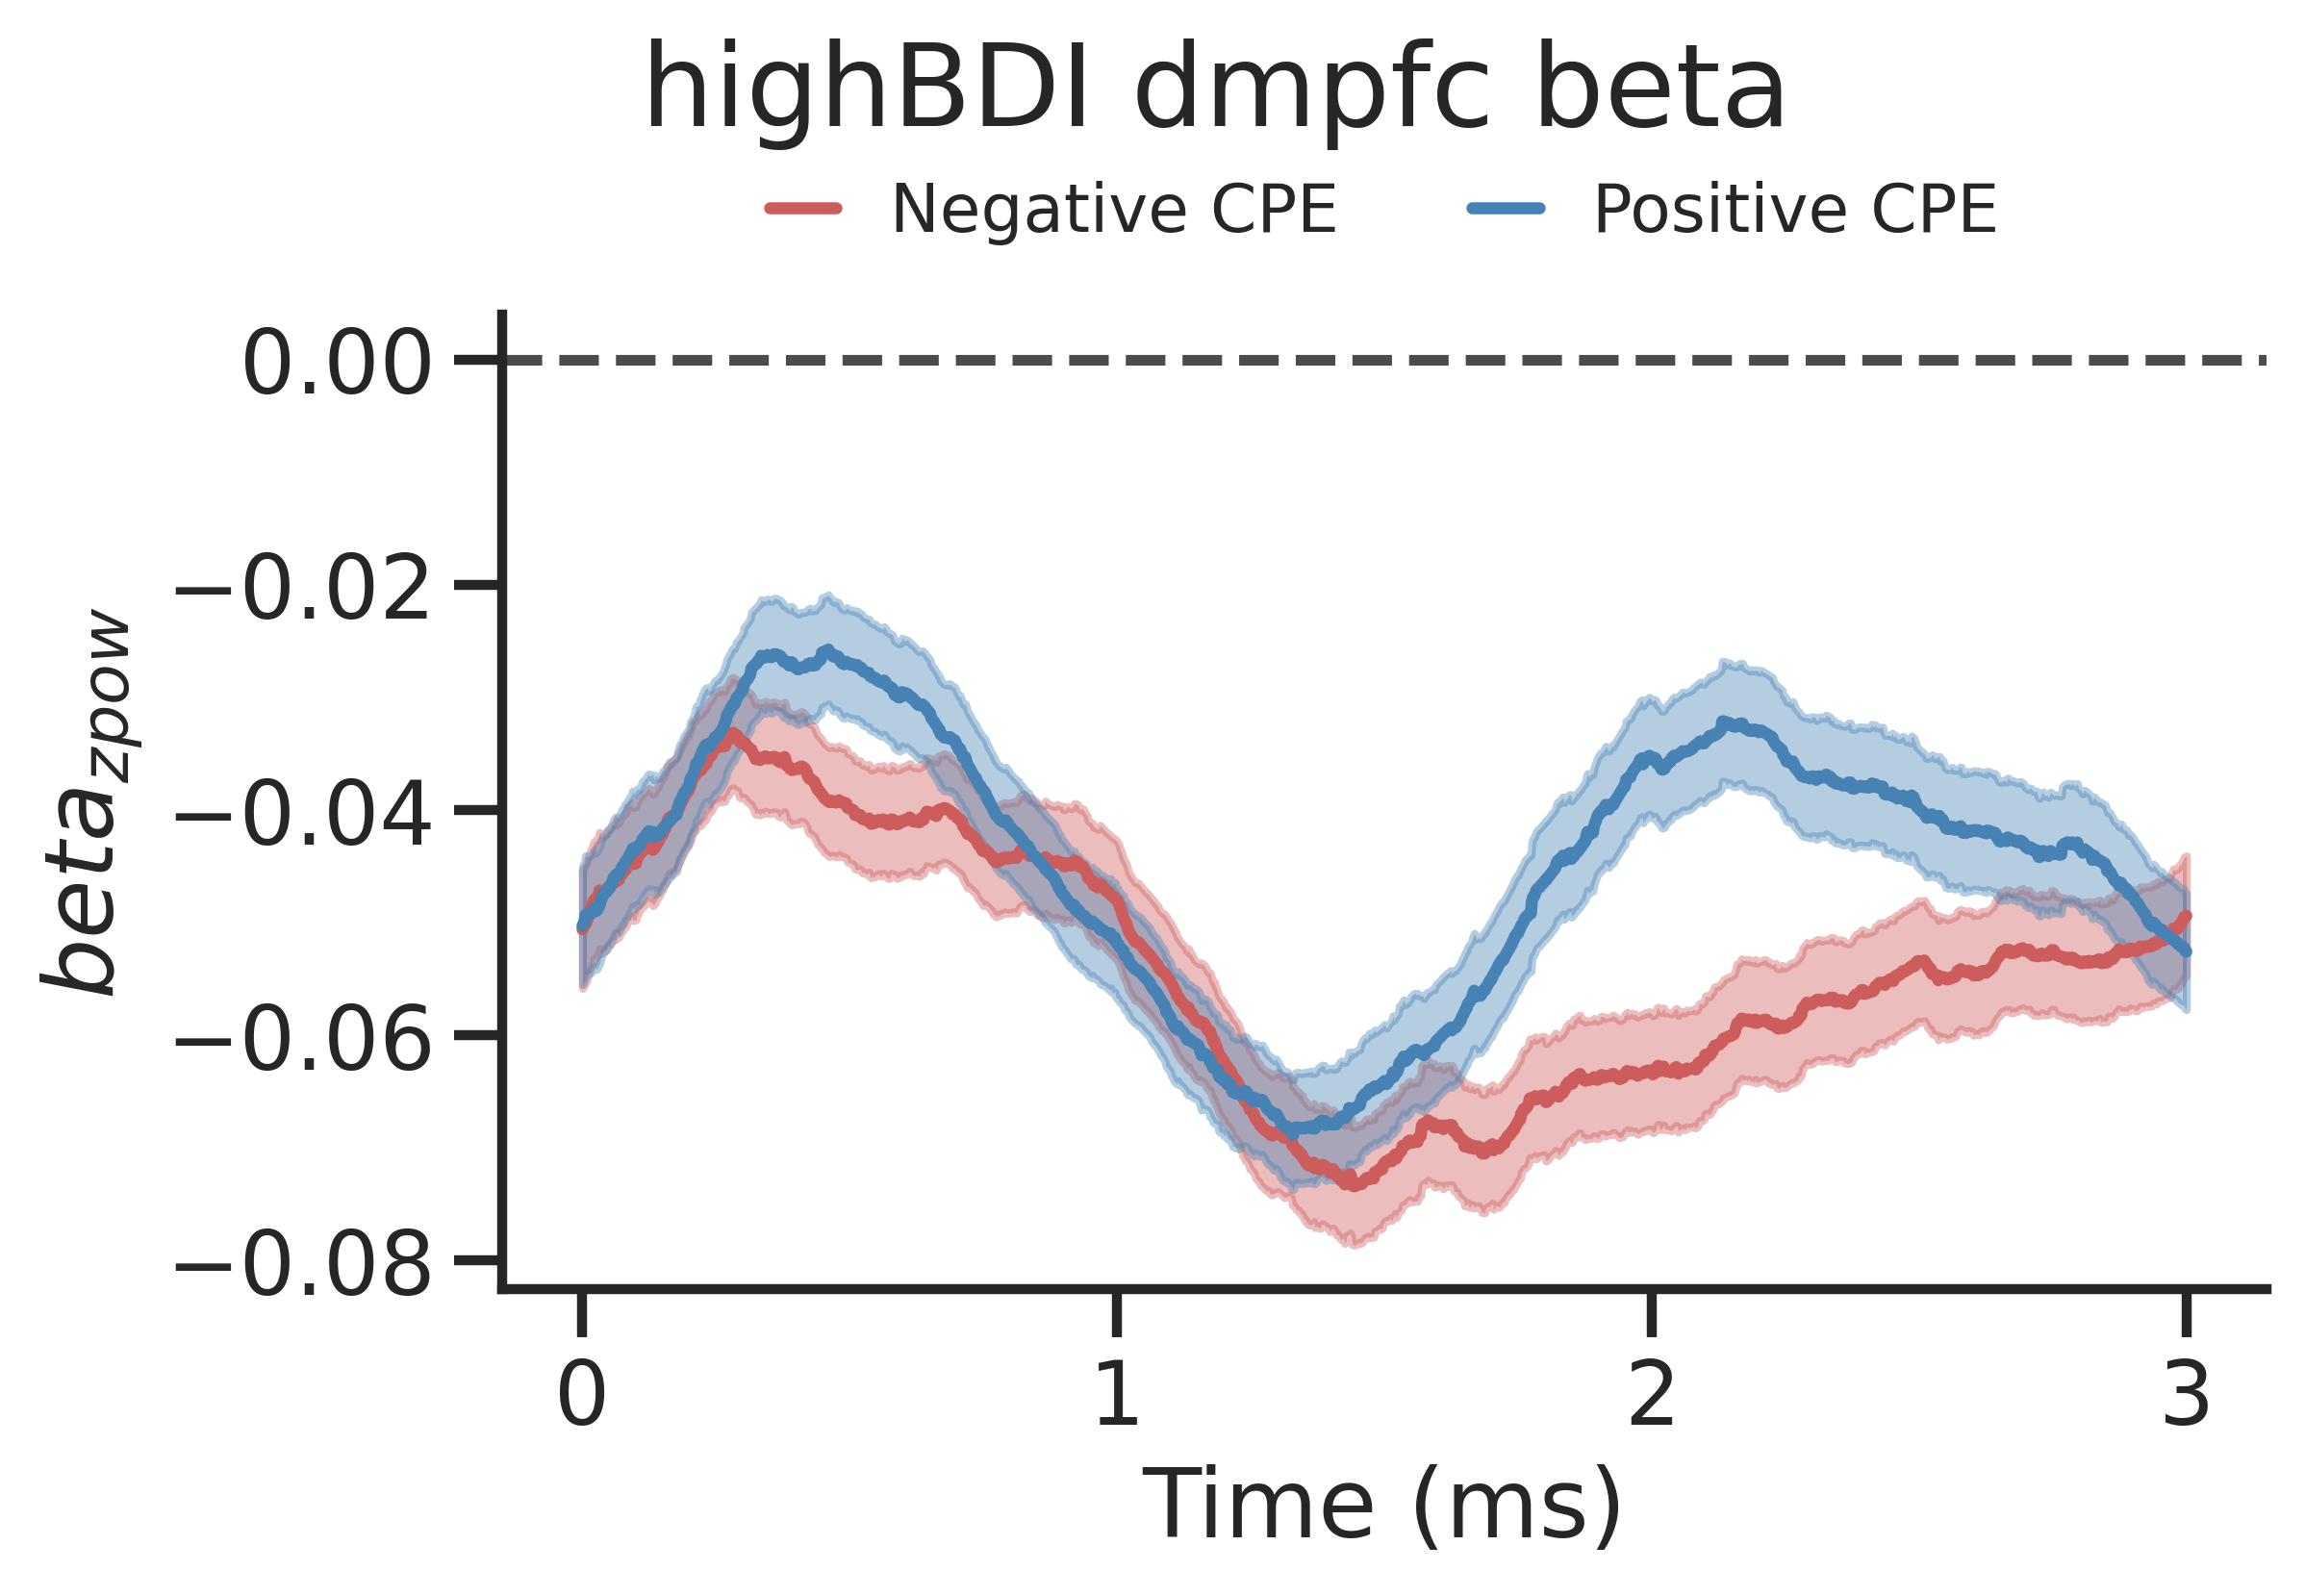

In [16]:
fig_dir   = f'{base_dir}ephys_analysis/figs/band_timeseries/{plot_band}/'
os.makedirs(fig_dir,exist_ok=True)
sem_colors = ['indianred','steelblue']
labels     = ['Negative CPE', 'Positive CPE']

roi_plot_df['bdi_split'] = roi_plot_df['bdi'].apply(lambda x: 0 if x < 20 else 1)

sns.set_context('talk')

for bdi_thresh in roi_plot_df.bdi_split.unique():
    bdi_data    = roi_plot_df[roi_plot_df.bdi_split == bdi_thresh].reset_index(drop=True)    
    
    bdi_data['new_pow'] = np.nan
    if bdi_thresh == 0:
        bdi = 'low'
    else:
        bdi = 'high'

    for elec in bdi_data.unique_reref_ch.unique().tolist():
        elec_df = bdi_data[bdi_data.unique_reref_ch == elec]
        elec_df['power'] = elec_df.band_pow.rolling(window=500).mean()
        bdi_data['new_pow'][bdi_data.unique_reref_ch == elec] = elec_df['power']

        
    power_avg = bdi_data.groupby(['time','cpe_split']).agg(power_mean=('new_pow', 'mean'), 
                                                    power_sem=('new_pow', lambda x: np.std(x)/np.sqrt(len(x)))
                                                    ).reset_index()

    fig_name     = f'{fig_dir}{bdi}BDI_{plot_roi}_{plot_band}.pdf'
    
    fig,ax    = plt.subplots(1,1,figsize=(6,4),dpi=400)
    plt.axhline(0, color='black', linestyle='--',linewidth=2,alpha=0.7)
#     plt.ylim([np.round(np.min(power_avg.power_mean),3),np.round(np.max(power_avg.power_mean),3)])
#     plt.ylim([np.round(np.min(power_avg.power_mean),2),np.round(np.abs(np.max(power_avg.power_mean)),2)])
    # Plot the time resolved power with SEM shading
    for i, cpe_split in enumerate(power_avg['cpe_split'].unique()):

        subset = power_avg[power_avg['cpe_split'] == cpe_split]

        plt.plot(subset['time'], subset['power_mean'], label=labels[i],color=sem_colors[i])
#         plt.ylim([np.round(np.min(power_avg.power_mean),2),np.round(np.abs(np.max(power_avg.power_mean)),2)])

        
        ax.legend(frameon=False,loc='upper center', bbox_to_anchor=(0.5, 0.5,0,0.7),ncol=2,
                framealpha=0,fontsize='x-small',shadow=None,markerscale=4,handlelength=1)

        plt.fill_between(subset['time'], subset['power_mean'] - subset['power_sem'], 
             subset['power_mean'] + subset['power_sem'], color=sem_colors[i], alpha=0.4)


    fig.tight_layout()
    fig.suptitle(f'{bdi}BDI {plot_roi} {plot_band}')
#     ax.set_title(f'{bdi}BDI {plot_roi} {plot_band}',fontsize=20)
    plt.xlabel(r'Time (ms)')
    
    plt.ylabel(fr'${plot_band}_{{zpow}}$')
    
    sns.despine()
    
    plt.savefig(fig_name,dpi=400,format='pdf', metadata=None,
    bbox_inches='tight', pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)

